Replicate simple sentiment classification baseline from this tutorial:

https://www.tensorflow.org/tutorials/keras/text_classification

using pytorch.

References:

- https://www.kaggle.com/code/affand20/imdb-with-pytorch

In [16]:
import pandas as pd
import re, string
from collections import Counter
from torch import nn
import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data
"""
Source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
https://ai.stanford.edu/~amaas/data/sentiment/
"""
data = pd.read_csv('../../local/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print (len(data))
print (data['sentiment'].value_counts())
data.head()

50000
positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# split into train, dev, test with percentages: 40%, 10%, 50% to match config used in the tensorflow tutorial

# shuffle data
data = data.sample(frac=1).reset_index(drop=True)

data = {
    'train': data[:20000].copy(),
    'dev': data[20000:25000].copy(),
    'test': data[25000:].copy()
}

In [4]:
def custom_standardization(input_data):
    lowercase = input_data.lower().replace('<br />', ' ')
    # Using Python's re.sub to replace punctuation with an empty string
    return re.sub('[%s]' % re.escape(string.punctuation), '', lowercase)

In [5]:
"""
Replicate this code for tensorflow:

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
"""

vocab_size = 10000
sequence_length = 250

# Step 1: Preprocess and Tokenize Text
tokenized_texts = [custom_standardization(text).split() for text in data['train']['review']]

# Step 2: Create a Vocabulary
vocab_counter = Counter(token for text in tokenized_texts for token in text)
vocab = {word: index + 2 for index, (word, count) in enumerate(vocab_counter.most_common(vocab_size - 2))}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token

# Step-3: Vectorize Text in train, val, test data using this vocab
def vectorize_text(text):
    word_ids = [vocab.get(token, vocab['<UNK>']) for token in custom_standardization(text).split()][:sequence_length]
    # pad to fixed length with pad token
    word_ids += [vocab['<PAD>']] * (sequence_length - len(word_ids))
    return word_ids

for key in data:
    data[key]['vectorized_review'] = data[key]['review'].apply(vectorize_text)

In [6]:
data['train']

,review,sentiment,vectorized_review
0,A movie about a mysterious love letter that pu...,negative,"[3, 17, 42, 3, 1279, 113, 2694, 12, 1381, 3, 3..."
1,This is a film that had a lot to live down to ...,negative,"[11, 7, 3, 19, 12, 63, 3, 160, 6, 427, 185, 6,..."
2,"A genuinely odd, surreal jumble of visual idea...",negative,"[3, 2005, 1029, 2307, 1, 5, 1108, 988, 61, 231..."
3,Here's yet another blasphemous European story ...,negative,"[1993, 241, 158, 1, 2103, 66, 8, 61, 34, 4653,..."
4,Robert Jordan is a television star. Robert Jor...,positive,"[624, 4946, 7, 3, 670, 345, 624, 4946, 1155, 1..."
...,...,...,...
19995,There will be a time where kids will have grow...,negative,"[47, 78, 26, 3, 58, 115, 351, 78, 25, 2263, 54..."
19996,I was 12 when this film was released and adore...,negative,"[10, 13, 1109, 50, 11, 19, 13, 585, 4, 1, 9, 2..."
19997,The ultimate gritty heist film. Elements of Bo...,positive,"[2, 1935, 2584, 3231, 19, 764, 5, 1, 3858, 308..."
19998,"Well, I set out with a few friends to see this...",negative,"[73, 10, 284, 44, 15, 3, 167, 331, 6, 67, 11, ..."


In [7]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(embed_dim, 1)  # Output layer for binary classification

    def forward(self, text):
        # text: [batch_size, seq_length]
        embedded = self.embedding(text)  # [batch_size, seq_length, embed_dim]
        embedded = self.dropout1(embedded)
        # Permute `embedded` to apply pooling across the embedding dimension
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embed_dim, seq_length]
        pooled = self.global_avg_pool(embedded)  # [batch_size, embed_dim, 1]
        pooled = pooled.squeeze(2)  # [batch_size, embed_dim]
        pooled = self.dropout2(pooled)
        return torch.sigmoid(self.fc(pooled))  # Apply sigmoid activation


In [8]:
embedding_dim = 16

model = TextClassificationModel(vocab_size, embedding_dim)

In [9]:
def manual_model_summary(model):
    print("Model Summary:")
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        print(f"{name}: {parameter.size()} => {param} parameters")
    print(f"Total Parameters: {total_params}")

print ("Manual model summary")
manual_model_summary(model)

print ("torchinfo summary")
summary(model, (32, sequence_length), dtypes=[torch.long])

Manual model summary
Model Summary:
embedding.weight: torch.Size([10000, 16]) => 160000 parameters
fc.weight: torch.Size([1, 16]) => 16 parameters
fc.bias: torch.Size([1]) => 1 parameters
Total Parameters: 160017
torchinfo summary


Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModel                  [32, 1]                   --
├─Embedding: 1-1                         [32, 250, 16]             160,000
├─Dropout: 1-2                           [32, 250, 16]             --
├─AdaptiveAvgPool1d: 1-3                 [32, 16, 1]               --
├─Dropout: 1-4                           [32, 16]                  --
├─Linear: 1-5                            [32, 1]                   17
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
Total mult-adds (M): 5.12
Input size (MB): 0.06
Forward/backward pass size (MB): 1.02
Params size (MB): 0.64
Estimated Total Size (MB): 1.73

In [10]:
# Loss function
loss_function = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Metrics
# For binary accuracy, we can define a function or use a library like torchmetrics
def binary_accuracy(preds, y):
    # Round predictions to the closest integer (0 or 1)
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()  # Convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [11]:
class ReviewSentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Assuming 'vectorized_review' is already a list of integers
        review = torch.tensor(row['vectorized_review'], dtype=torch.long)
        # Convert 'sentiment' to a binary label (0 or 1)
        sentiment = torch.tensor(1 if row['sentiment'] == 'positive' else 0, dtype=torch.float)
        return review, sentiment

In [12]:
# Assuming train_ds and val_ds are PyTorch Dataset objects
train_loader = DataLoader(ReviewSentimentDataset(data['train']), batch_size=32, shuffle=True)
val_loader = DataLoader(ReviewSentimentDataset(data['dev']), batch_size=32)

epochs = 10
device = 'cuda'
history = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")  # Wrap train_loader with tqdm
    for texts, labels in train_progress_bar:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)

        loss = loss_function(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        history.append({
            'epoch': epoch,
            'split': 'train',
            'loss': loss.item(),
            'acc': acc.item()
        })

    epoch_train_stats = pd.DataFrame(history).query(f"epoch == {epoch} and split == 'train'")
    loss = epoch_train_stats['loss'].mean()
    acc = epoch_train_stats['acc'].mean()
    print (f"Epoch {epoch} train loss: {loss:.4f}, acc: {acc:.4f}")
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            loss = loss_function(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            history.append({
                'epoch': epoch,
                'split': 'dev',
                'loss': loss.item(),
                'acc': acc.item()
            })
        
        epoch_dev_stats = pd.DataFrame(history).query(f"epoch == {epoch} and split == 'dev'")
        loss = epoch_dev_stats['loss'].mean()
        acc = epoch_dev_stats['acc'].mean()
        print (f"Epoch {epoch} dev loss: {loss:.4f}, acc: {acc:.4f}")
    

Epoch 1/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 train loss: 0.6898, acc: 0.5447
Epoch 0 dev loss: 0.6800, acc: 0.6361


Epoch 2/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 train loss: 0.6583, acc: 0.6526
Epoch 1 dev loss: 0.6312, acc: 0.7122


Epoch 3/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2 train loss: 0.5962, acc: 0.7219
Epoch 2 dev loss: 0.5626, acc: 0.7725


Epoch 4/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3 train loss: 0.5287, acc: 0.7666
Epoch 3 dev loss: 0.4978, acc: 0.8093


Epoch 5/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4 train loss: 0.4679, acc: 0.8068
Epoch 4 dev loss: 0.4442, acc: 0.8320


Epoch 6/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5 train loss: 0.4205, acc: 0.8306
Epoch 5 dev loss: 0.4038, acc: 0.8443


Epoch 7/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6 train loss: 0.3833, acc: 0.8488
Epoch 6 dev loss: 0.3753, acc: 0.8509


Epoch 8/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7 train loss: 0.3535, acc: 0.8607
Epoch 7 dev loss: 0.3551, acc: 0.8567


Epoch 9/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8 train loss: 0.3324, acc: 0.8687
Epoch 8 dev loss: 0.3396, acc: 0.8607


Epoch 10/10 [Training]:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9 train loss: 0.3178, acc: 0.8733
Epoch 9 dev loss: 0.3286, acc: 0.8629


In [28]:
test_loader = DataLoader(ReviewSentimentDataset(data['test']), batch_size=32)
model.eval()
total_loss, total_acc = 0, 0

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = loss_function(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        # print (predictions, labels)
        # assert False
        total_loss += loss.item()
        total_acc += acc.item()

avg_loss = total_loss / len(test_loader)
avg_acc = total_acc / len(test_loader)
print("Loss: ", avg_loss)
print("Accuracy: ", avg_acc)

Loss:  0.33930124266220785
Accuracy:  0.8600543478260869


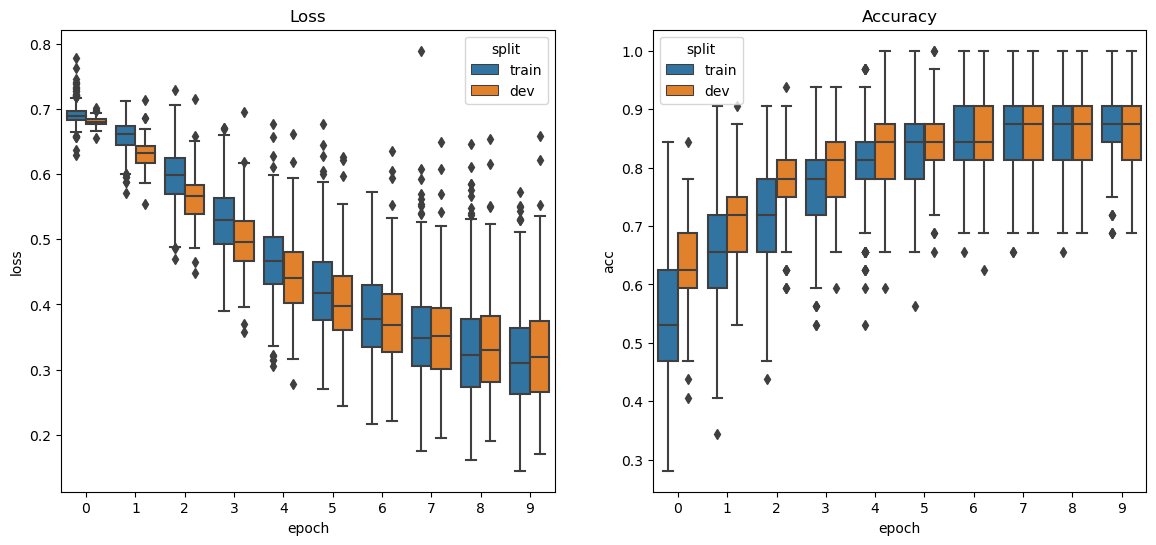

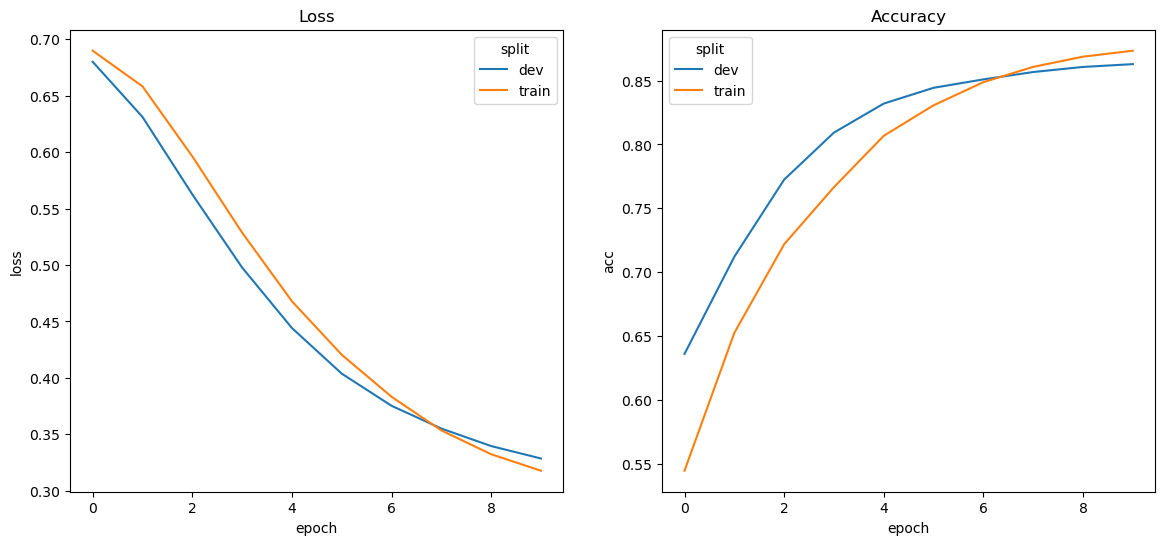

In [29]:
# plot train and validation loss and accuracy over epochs
# for each epoch, show a box plot of the loss and accuracy
history_df = pd.DataFrame(history)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='epoch', y='loss', hue='split', data=history_df)
plt.title("Loss")
plt.subplot(1, 2, 2)
sns.boxplot(x='epoch', y='acc', hue='split', data=history_df)
plt.title("Accuracy")
plt.show()

# do same plots but only show mean instead of box plot
history_df = pd.DataFrame(history).groupby(['epoch', 'split']).mean().reset_index()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='epoch', y='loss', hue='split', data=history_df)
plt.title("Loss")
plt.subplot(1, 2, 2)
sns.lineplot(x='epoch', y='acc', hue='split', data=history_df)
plt.title("Accuracy")
plt.show()

In [35]:
# make predictions on new data

def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        text = torch.tensor([vectorize_text(text)], dtype=torch.long).to(device)
        prediction = model(text).item()
        return 'positive' if prediction > 0.5 else 'negative', prediction

In [36]:
sample_inputs = [
    "This movie is fantastic!",
    "I really liked the movie",
    "Not a good movie",
    "I will never recommend this movie to anyone",
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
    "terrible awful bad",
    "The movie was great and wonderful! But the popcorn we had there was terrible, awful, bad, the worst I've ever had."
]

for text in sample_inputs:
    label, prob = predict_sentiment(text)
    print(f"{text} -> {label} (positive probability: {prob})\n")

This movie is fantastic! -> positive (positive probability: 0.594059407711029)

I really liked the movie -> positive (positive probability: 0.5776623487472534)

Not a good movie -> positive (positive probability: 0.5234923362731934)

I will never recommend this movie to anyone -> positive (positive probability: 0.5847715139389038)

The movie was great! -> positive (positive probability: 0.6081189513206482)

The movie was okay. -> negative (positive probability: 0.4714812636375427)

The movie was terrible... -> negative (positive probability: 0.3927673101425171)

terrible awful bad -> negative (positive probability: 0.20684494078159332)

The movie was great and wonderful! But the popcorn we had there was terrible, awful, bad, the worst I've ever had. -> negative (positive probability: 0.19370687007904053)

